# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind
from numpy.random import seed
medical = pd.read_csv('insurance2.csv')

In [4]:
medical.shape

(1338, 8)

In [5]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

In [25]:
charges_mean = np.mean(medical['charges'])
s = np.std(medical['charges'], ddof=1)
print("The mean charge of the sample observations is",'${:0,.2f}'.format(charges_mean))
print("The standard deviation of the charges in the sample is", '${:0,.2f}'.format(s))

The mean charge of the sample observations is $13,270.42
The standard deviation of the charges in the sample is $12,110.01


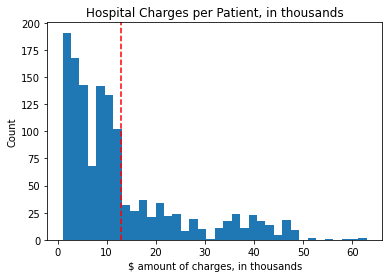

In [24]:
_ = plt.hist(medical['charges']//1000, bins=int(np.sqrt(len(medical['charges']))))
_ = plt.xlabel('$ amount of charges, in thousands')
_ = plt.ylabel('Count')
_ = plt.title('Hospital Charges per Patient, in thousands')
_ = plt.axvline(charges_mean//1000, color='r', linestyle='--')

The data is skewed, so the mean is affected by outliers, and the standard deviation is very large and does not reflect a normal distribution. 

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__  Because these data represent a random sample of charges, and the number of observations is well over the 30 observations often cited as minimum, we can use the Central Limit Theorem to say that the distribution of the means is likely normal. We can re-sample the data and look at the distribution of statistics, and extrapolate information about the population as a whole from our sample. 

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__ Let's use a one-sided interval because the adminstrator is concerned that the mean may be **less** than $12,000. A 95% confidence interval will suffice. 

In [64]:
def sampler(n):
    return medical.sample(n)

In [65]:
sampler(1)

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
167,32,0,33.155,3,0,1,6128.79745,0


In [67]:
means = pd.DataFrame({'meancharges': [sampler(100).charges.mean() for i in range(1000)]})
grandmeans = np.mean(means)

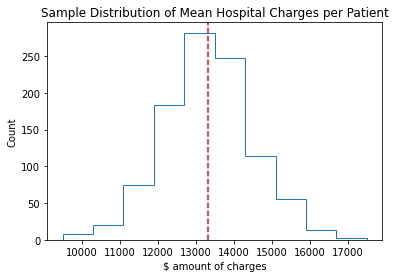

In [68]:
_ = plt.hist(means['meancharges'], bins=10, histtype='step')
_ = plt.xlabel('$ amount of charges')
_ = plt.ylabel('Count')
_ = plt.title('Sample Distribution of Mean Hospital Charges per Patient')
_ = plt.axvline(grandmeans['meancharges'], color='r', linestyle='--')

In [71]:
# Standard deviation of the means distribution, estimated
std_distofmeans = np.std(means['meancharges'])
# Standard deviation of the means distribution from CLT
exp_std_from_clt = s/np.sqrt(100)
print("The calculated standard deviation from the distribution of means is",
     '${:0,.2f}'.format(std_distofmeans))
print("The expected standard deviation of the distribution of means from the CLT is",
     '${:0,.2f}'.format(exp_std_from_clt))

The calculated standard deviation from the distribution of means is $1,154.64
The expected standard deviation of the distribution of means from the CLT is $1,211.00


Because we don't know the statistics of the population as a whole, we will use the t-value to find the 95% confidence interval. 

In [72]:
t.interval(alpha=0.95, df=len(means['meancharges'])-1, loc=grandmeans['meancharges'], scale=s/np.sqrt(100)) 

(10938.32876791187, 15691.124196823184)

In [79]:
#Calculate the p-value of $12,000
(norm(grandmeans['meancharges'], exp_std_from_clt).cdf(12000))*100

13.881636606081393

Using these outcomes, we cannot say for certainty that the mean charge of all hospital patients is above $12,000. 

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__ The null hypothesis is people with insurance are not charged a different amount to those without. The alternative hypothesis is people with insurance are charged a different amount to those without. We are assuming that the variance of both groups is similar (the people with and without insurance had similar types of charges) and that the resulting sets of observations are independent. 

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [110]:
insurance = medical[medical['insuranceclaim'] == 1]['charges']
cash = medical[medical['insuranceclaim'] == 0]['charges']

In [114]:
s_pooled = np.sqrt((((len(insurance) -1)* insurance.std()**2) + ((len(cash) -1)* cash.std()**2))/(len(cash) + len(insurance) -2))

In [115]:
s_pooled

11520.034268775256

In [117]:
# Calculate t-test statistic
t = (np.mean(insurance) - np.mean(cash))/(s_pooled*(np.sqrt((1/len(insurance)) + (1/len(cash)))))
print(t)

11.89329903087671


In [119]:
ttest_ind(insurance, cash)

Ttest_indResult(statistic=11.893299030876712, pvalue=4.461230231620717e-31)

The p-value is very small, p<<.001. Because the p-value is very small, we should reject the null hypothesis, which is, we reject the hypothesis that patients with insurance are charged the same as patients without insurance.

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ I don't see a similar statistical test for performing a z-test from a sample. This might be because you can calculate the z-score you know the sample conforms to a normal distribution, and you have the standard deviation of the population. 

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test